In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

## Content
+ EDA analysis to find the demographic distribution of the users
+ EDA analysis on the relationship between source of the customers' and conversion rate
+ Penalized Logistic Regression Model on predicting the conversion result
+ Actionable insights on marketing, sales and growth team

## Define the business Problem

What features can contribute to the conversion rate?

How to improve our conversion rate?

## Understand the data

In [14]:
## load in the data and inspect the data set
conversion=pd.read_csv("E:/DataArtist/THC/Cr/conversion_data.csv")
conversion.head(10)

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0
5,US,31,0,Seo,1,0
6,China,27,1,Seo,4,0
7,US,23,0,Ads,4,0
8,UK,29,0,Direct,4,0
9,US,25,0,Ads,2,0


In [15]:
## check the data structure
conversion.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316200 entries, 0 to 316199
Data columns (total 6 columns):
country                316200 non-null object
age                    316200 non-null int64
new_user               316200 non-null int64
source                 316200 non-null object
total_pages_visited    316200 non-null int64
converted              316200 non-null int64
dtypes: int64(4), object(2)
memory usage: 14.5+ MB


In [6]:
## Check the missing value/wrong data and wired data

In [16]:
conversion.isnull().any()

country                False
age                    False
new_user               False
source                 False
total_pages_visited    False
converted              False
dtype: bool

In [16]:
## Descriptive statistics and deal with outliers

In [17]:
conversion.describe()

,age,new_user,total_pages_visited,converted
count,316200.000000,316200.000000,316200.000000,316200.000000
mean,30.569858,0.685465,4.872966,0.032258
std,8.271802,0.464331,3.341104,0.176685
min,17.000000,0.000000,1.000000,0.000000
25%,24.000000,0.000000,2.000000,0.000000
50%,30.000000,1.000000,4.000000,0.000000
75%,36.000000,1.000000,7.000000,0.000000
max,123.000000,1.000000,29.000000,1.000000


The conversion rate is 3% and it's around the industry standard.

The age 123 is definitely wired number needs to be dealt with.

In [12]:
print(sorted(conversion["age"].unique()))

[17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 72, 73, 77, 79, 111, 123]


In [18]:
# Handling the outlier in age column
# This might be due to miss typing
conversion.loc[conversion.age>100,:]

,country,age,new_user,source,total_pages_visited,converted
90928,Germany,123,0,Seo,15,1
295581,UK,111,0,Ads,10,1


In [19]:
## Data Cleaning
# Substitute the outlier age with median
medianage=conversion.age.median()
conversion["age"]=np.where(conversion["age"]>100,medianage,conversion["age"])

## Exploratory Data Analysis

Visualize the univarite and bivarite variables by plotting them

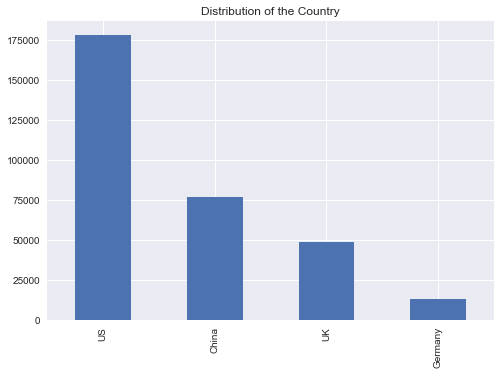

In [9]:
fig,axes=plt.subplots(nrows=1,ncols=1)
country_distribution=conversion["country"].value_counts()
country_distribution.plot(kind="bar")
axes.set_title("Distribution of the Country")

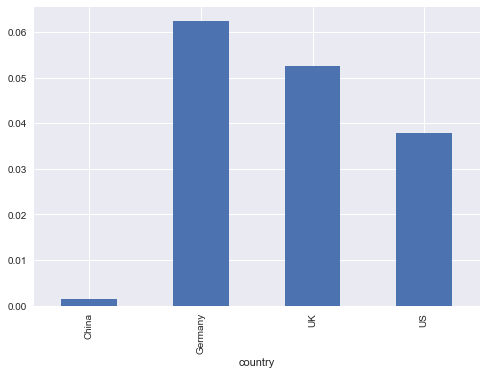

In [10]:
# calculate the conversion rate
convert_ratio_by_country=conversion.groupby(conversion["country"])["converted"].mean()
convert_ratio_by_country.plot(kind="bar")

From the above figures we can find the insights
+ A lot of users are coming from China, but the conversion rate in China is extremely low
+ The conversion rate in Europe Market is realtively high

In [66]:
## Inspect Ages' Distribution and Its Relationship With Conversion Rate

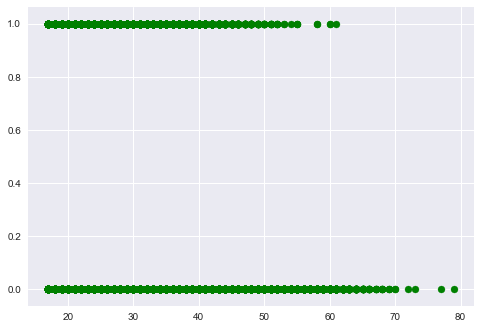

In [11]:
plt.scatter(conversion["age"],conversion["converted"],c="green")

We find that no viewers convert into real users when they are above 60

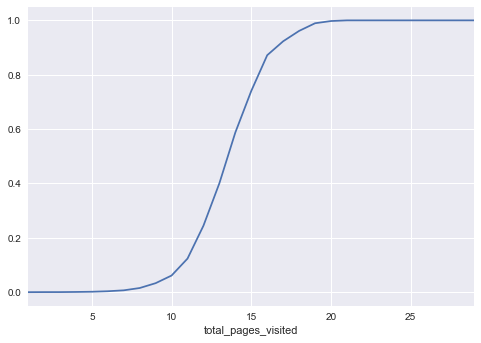

In [22]:
conversion_page_viewed_rate=conversion.groupby(conversion["total_pages_visited"])["converted"].mean()
conversion_page_viewed_rate.plot()

We can find that they more time they spend on the pages the more likely they are converted to real customers and the 10 and 20 are the key page numbers that lead to the change of conversion rate.

In [67]:
## Inspect Source Distribution and Its Relationship With Conversion Rate

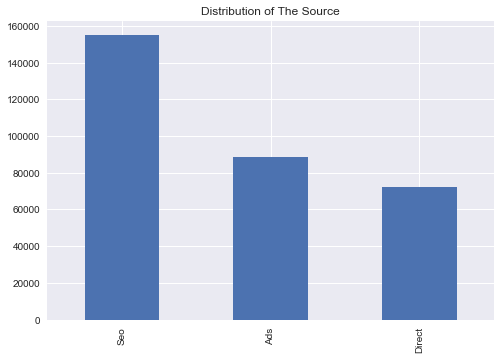

In [12]:
fig,axes=plt.subplots(nrows=1,ncols=1)
country_distribution=conversion['source'].value_counts()
ax=country_distribution.plot(kind="bar")
ax.set_title("Distribution of The Source")

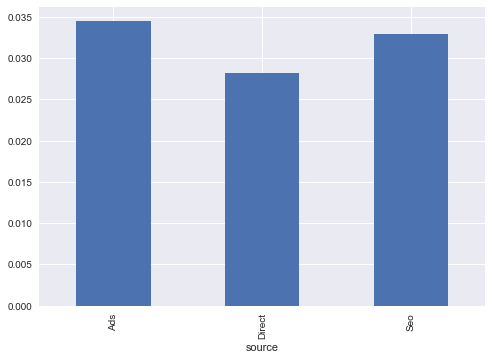

In [13]:
convert_ratio_by_country=conversion.groupby("source")["converted"].mean()
convert_ratio_by_country.plot(kind="bar")

From the above figures we can find the insights
+ The majority of the traffic is coming from the SEO and then Ads
+ The conversion rate from three traffic sources are almost the same

## Feature Engineering

In [14]:
conversion.head(5)

,country,age,new_user,source,total_pages_visited,converted
0,UK,25.0,1,Ads,1,0
1,US,23.0,1,Seo,5,0
2,US,28.0,1,Seo,4,0
3,China,39.0,1,Seo,5,0
4,US,30.0,1,Seo,6,0


In [20]:
# Use one hot coding to change catergorical data into numerical variables
# Prepare for the X matrix
newcv=conversion.loc[:,('country','age','new_user','source','total_pages_visited')]
X=pd.get_dummies(newcv)
# Prepare for te Y matrix
Y=conversion['converted']

The data is very imbalanced. We will choose more metrics as AUC instead of just accuracy rate to tackle this problem

In [21]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.3,random_state=42)

In [24]:
Y_train.mean(),Y_test.mean()

(0.032474925454052589, 0.031752055660974068)

## Modeling and Optimization

### Penalized Logistic Regression Model

In [31]:
# Built up a penalized logistic regression model
# Why Lasso Logistic Regression Model?
from sklearn.linear_model import LogisticRegressionCV
# built the model 
LR=LogisticRegressionCV(Cs = np.logspace(-3,3,7),
                       dual=False,
                       scoring='roc_auc',
                       max_iter=1000,
                       n_jobs=-1,
                       verbose=1)
LR.fit(X_train,Y_train)

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   18.3s finished


LogisticRegressionCV(Cs=array([  1.00000e-03,   1.00000e-02,   1.00000e-01,   1.00000e+00,
         1.00000e+01,   1.00000e+02,   1.00000e+03]),
           class_weight=None, cv=None, dual=False, fit_intercept=True,
           intercept_scaling=1.0, max_iter=1000, multi_class='ovr',
           n_jobs=-1, penalty='l2', random_state=None, refit=True,
           scoring='roc_auc', solver='lbfgs', tol=0.0001, verbose=1)

In [32]:
LR.score(X_train,Y_train)

0.98627450980392162

In [33]:
LR.score(X_test,Y_test)

0.98627450980392162

In [36]:
from sklearn.metrics import classification_report,confusion_matrix
Y_predict=LR.predict(X_test)
print (classification_report(Y_test,Y_predict))

             precision    recall  f1-score   support

          0       0.99      1.00      0.99     91848
          1       0.85      0.69      0.76      3012

avg / total       0.99      0.99      0.99     94860



From the output table, we can find that for all the labels classified as converted users, 85% of them are true converted users.

For all of the customers who are actually converted users, 69% of them are classifed as converted users.

Based on the reasoning above, we can find that around 1-69%=31% of converted users are classified as non-converted users.

If we want to increase our models' capability to detect the potential converting customers, we can reach our decision boundary further from 0.5 to 0.7 or 0.8.



In [39]:
feat_importances = pd.DataFrame({"name":X_train.columns,"coef":LR.coef_[0]})
feat_importances = feat_importances[['name','coef']]# reorder the columns
feat_importances['importances'] = np.abs( feat_importances['coef'] )
feat_importances.sort_values(by="importances",inplace=True,ascending=False)
feat_importances

,name,coef,importances
3,country_China,-2.656274,2.656274
1,new_user,-1.745113,1.745113
4,country_Germany,1.078791,1.078791
5,country_UK,0.908833,0.908833
2,total_pages_visited,0.762337,0.762337
6,country_US,0.509921,0.509921
8,source_Direct,-0.166207,0.166207
0,age,-0.076551,0.076551
7,source_Ads,0.006849,0.006849
9,source_Seo,0.000628,0.000628


### Random Forest Model

In this case, we also choose random forset model to predict the conversion rate for the following reasons:
+ It requires very little time to optimize it, the default value are very close to the best ones
+ Random forest model is very robust dealing with outliers
+ Random forest model can use its partial dependence plots to give us the variable importance
+ Use single tree to visualize the user segments and compare the results with random forest model output

Setting the two main parameters in this random forset model
+ n_estomators=100
+ max_features=sqrt(n_variables)

In [22]:
from sklearn.ensemble import RandomForestClassifier
RF=RandomForestClassifier(n_estimators=100,max_features=3,max_depth=None,min_samples_split=2,random_state=0)

In [23]:
RF.fit(X_train,Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=3, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=0,
            verbose=0, warm_start=False)

In [24]:
RF.score(X_train,Y_train)

0.98840697569350322

In [25]:
RF.score(X_test,Y_test)

0.98465106472696606

We further check the variable importance

In [31]:
indices

array([2, 0, 1, 3, 5, 6, 4, 9, 8, 7], dtype=int64)

In [29]:
importances = RF.feature_importances_
std = np.std([tree.feature_importances_ for tree in RF.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

1. feature 2 (0.805276)
2. feature 0 (0.114644)
3. feature 1 (0.038632)
4. feature 3 (0.022174)
5. feature 5 (0.004423)
6. feature 6 (0.003832)
7. feature 4 (0.002924)
8. feature 9 (0.002882)
9. feature 8 (0.002642)
10. feature 7 (0.002571)


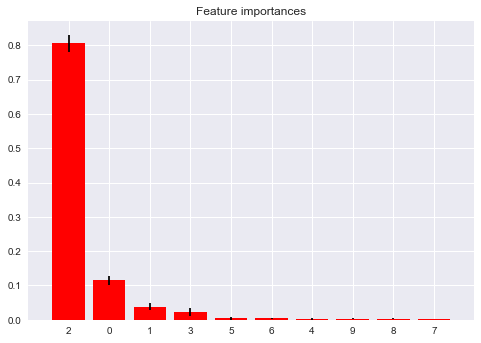

In [30]:
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

From the above analysis, we can find that the top 4 important features are as follows:

In [38]:
Top4Features=[list(X_train)[2],list(X_train)[0],list(X_train)[1],list(X_train)[3]]
print (Top4Features)

['total_pages_visited', 'age', 'new_user', 'country_China']


+ From both the penalized logistic regression model and random forest model, we can find that new_user and country might be the most two important factors contributing to the conversion rate.
+ Source is the most irrelevant variables.

In [40]:
# Build a simple decision tree to further validate our guesses

In [42]:
from sklearn import tree
clf=tree.DecisionTreeClassifier()
clf=clf.fit(X_train,Y_train)

## Communication and Actionable Insights

We can drae several insights from the above analysis:

+ The conversion rate from China is very low, this is a potentially huge market and our company should really work on this
+ Comparing with new users, old users have a high conversion rate and we should put high priority marketing force on them
+ Counter intitutively, users coming from ads and seo tend to have a higher conversion rate than users coming directly.
+ German users have a high conversion rate.
+ The conversion rate has a positive correlation between the pages user viewed. We should remind users who have viewed a lot of our pages to buy things

## Discussion and Further Improvements

+ This project can be improved by assigning a real-time probability of conversion to each customer, this will definitely help our marketing and sales team make their strategy.
+ We can also use some neural network models on this in order to get a better temporal structure on the data.
+ We can optimize the ROC and do further cut-off analysis to minimize the false positive/false negative ratio.